# Data Preprocessing for Traffic Video Analysis

## Current Data Collection and Storage Infrastructure

### Recording System
- **Stream Collection**: RTSP collector scripts capture live traffic camera feeds via sidecar wrapper
- **System Integration**: Scripts run as Debian system services for continuous recording
- **Recording Duration**: Currently recording each videos with a duraction of 15-minutes
- **Recording Interval**: New files created every 70 seconds with 60-second content
- **Active Cameras**: 7 traffic cameras recording continuously

### Video Specifications
- **Resolution**: 480x270 pixels
- **Frame Rate**: 15 fps
- **Codec**: H.264
- **Format**: MP4
- **File Size**: ~1MB per minute
- **Storage Growth**: ~10GB/day across all cameras
- **Status**: All recordings verified and playable

### Active Camera Locations

| Camera ID | Location | Stream URL |
|-----------|----------|------------|
| ATL-0610 | 10th St at Monroe Dr (Atlanta) | https://sfs-msc-pub-lq-01.navigator.dot.ga.gov:443/rtplive/ATL-CCTV-0610/playlist.m3u8 |
| ATL-0907 | Piedmont Ave at 14th St (Atlanta) | https://sfs-msc-pub-lq-01.navigator.dot.ga.gov:443/rtplive/ATL-CCTV-0907/playlist.m3u8 |
| ATL-0972 | Peachtree St at 5th St (Atlanta) | https://sfs-msc-pub-lq-01.navigator.dot.ga.gov:443/rtplive/ATL-CCTV-0972/playlist.m3u8 |
| ATL-0997 | West Peachtree St at 5th St (Atlanta) | https://sfs-msc-pub-lq-01.navigator.dot.ga.gov:443/rtplive/ATL-CCTV-0997/playlist.m3u8 |
| ATL-0998 | West Peachtree St at 17th St (Atlanta) | https://sfs-msc-pub-lq-01.navigator.dot.ga.gov:443/rtplive/ATL-CCTV-0998/playlist.m3u8 |
| ATL-0999 | West Peachtree St at 14th St (Atlanta) | https://sfs-msc-pub-lq-01.navigator.dot.ga.gov:443/rtplive/ATL-CCTV-0999/playlist.m3u8 |
| ATL-1005 | Peachtree St at 12th St (Atlanta) | https://sfs-msc-pub-lq-01.navigator.dot.ga.gov:443/rtplive/ATL-CCTV-1005/playlist.m3u8 |

### Directory Structure
The traffic camera recordings are stored locally with the following hierarchical organization:

```
traffic-recordings/
├── ATL-0610/           # Location identifier
│   ├── 2025-06-09/     # Date-based subdirectory
│   ├── 2025-06-10/
│   ├── 2025-06-11/
│   └── 2025-06-12/
├── ATL-0907/
├── ATL-0972/
├── ATL-0997/
└── ...
```

### File Details
- **Total Structure**: 44 directories, 1,860 video files
- **Locations**: Multiple Atlanta highway cameras (ATL-0610, ATL-0907, ATL-0972, ATL-0997, ATL-0998, ATL-0999, ATL-1005)
- **Time Period**: June 9-12, 2025 (4 days of recordings)
- **Files per Day**: Approximately 80-85 recordings per location per day

### File Naming Convention
All video files follow a consistent naming pattern:
```
LOCATION_YYYYMMDD_HHMMSS.mp4
```
Example: `ATL-0610_20250609_011004.mp4`
- Location: ATL-0610
- Date: 2025-06-09
- Time: 01:10:04

### File Characteristics
- **Format**: MP4 video files
- **Size Range**: 982KB - 8.7MB per file
- **Average Size**: ~6-7MB per recording
- **Recording Interval**: Appears to be captured at regular intervals throughout each day

### Storage Organization Diagram

```mermaid
graph TD
    A[traffic-recordings/] --> B[ATL-0610/]
    A --> C[ATL-0907/]
    A --> D[ATL-0972/]
    A --> E[ATL-0997/]
    A --> F[... more locations]
    
    B --> B1[2025-06-09/<br/>81 files]
    B --> B2[2025-06-10/<br/>84 files]
    B --> B3[2025-06-11/<br/>85 files]
    B --> B4[2025-06-12/<br/>6 files]
    
    B1 --> G[ATL-0610_20250609_011004.mp4<br/>6.8MB]
    B1 --> H[ATL-0610_20250609_012625.mp4<br/>6.7MB]
    B1 --> I[... 79 more files]
    
    style A fill:#f9f,stroke:#333,stroke-width:4px
    style B fill:#bbf,stroke:#333,stroke-width:2px
    style C fill:#bbf,stroke:#333,stroke-width:2px
    style D fill:#bbf,stroke:#333,stroke-width:2px
    style E fill:#bbf,stroke:#333,stroke-width:2px
```

### Storage Considerations for Preprocessing
- All data is stored locally on the HPC workstation
- No cloud storage dependencies
- Direct file system access for processing
- Organized structure enables easy batch processing by location or date

This notebook will establish preprocessing workflows to prepare these traffic recordings for object detection and tracking model training.

## Environment Setup and Path Verification

The following cell establishes the notebook environment and verifies all required paths and scripts are accessible.

In [2]:
# Import libraries for notebook workflow
import subprocess
import json
from pathlib import Path
import pandas as pd

# Define paths
PROJECT_ROOT = Path.cwd().parent.parent  # Adjust based on notebook location
SCRIPTS_DIR = PROJECT_ROOT / "scripts"
FRAMES_DIR = PROJECT_ROOT / "frames"
RECORDINGS_DIR = Path("/home/trauco/traffic-recordings")

# Verify paths
print(f"Project root: {PROJECT_ROOT}")
print(f"Scripts directory exists: {SCRIPTS_DIR.exists()}")
print(f"Preprocessing script exists: {(SCRIPTS_DIR / 'preprocess_daytime_videos.py').exists()}")
print(f"Recordings directory exists: {RECORDINGS_DIR.exists()}")

Project root: /home/trauco/data-science-sad
Scripts directory exists: True
Preprocessing script exists: True
Recordings directory exists: True


## Test Preprocessing Script Execution

This cell tests the preprocessing script by extracting frames from one 13:00 EST video from each available camera to verify the workflow across all camera locations.

## Verify Preprocessing Output

The next cell checks if frames were successfully extracted and examines the output structure, including the generated frame files and metadata.

In [4]:
# Check if frames were extracted
frames_output = FRAMES_DIR / camera_id / date
print(f"Checking output directory: {frames_output}")

if frames_output.exists():
    # List all video folders processed
    video_folders = list(frames_output.iterdir())
    print(f"\nFound {len(video_folders)} processed video(s):")
    
    for folder in video_folders:
        print(f"\n{folder.name}:")
        
        # Count frames
        frames = list(folder.glob("*.jpg"))
        print(f"  - Frames extracted: {len(frames)}")
        
        # Check metadata
        metadata_file = folder / "metadata.json"
        if metadata_file.exists():
            with open(metadata_file, 'r') as f:
                metadata = json.load(f)
            print(f"  - Original FPS: {metadata['fps_original']}")
            print(f"  - Sampled FPS: {metadata['fps_sampled']}")
            print(f"  - Duration: {metadata['duration_seconds']}s")
            print(f"  - Avg brightness: {metadata['quality_stats']['avg_brightness']:.1f}")
            print(f"  - Avg blur score: {metadata['quality_stats']['avg_blur_score']:.1f}")
else:
    print("No output found - check preprocessing script output for errors")

Checking output directory: /home/trauco/data-science-sad/frames/ATL-0610/2025-06-09

Found 1 processed video(s):

ATL-0610_20250609_011004:
  - Frames extracted: 129
  - Original FPS: 14.999816885928812
  - Sampled FPS: 2
  - Duration: 60s
  - Avg brightness: 80.6
  - Avg blur score: 3992.3


## Visualize Sample Frames

The following cell displays a grid of sample frames from the processed video to visually inspect the quality and content of the extracted frames.

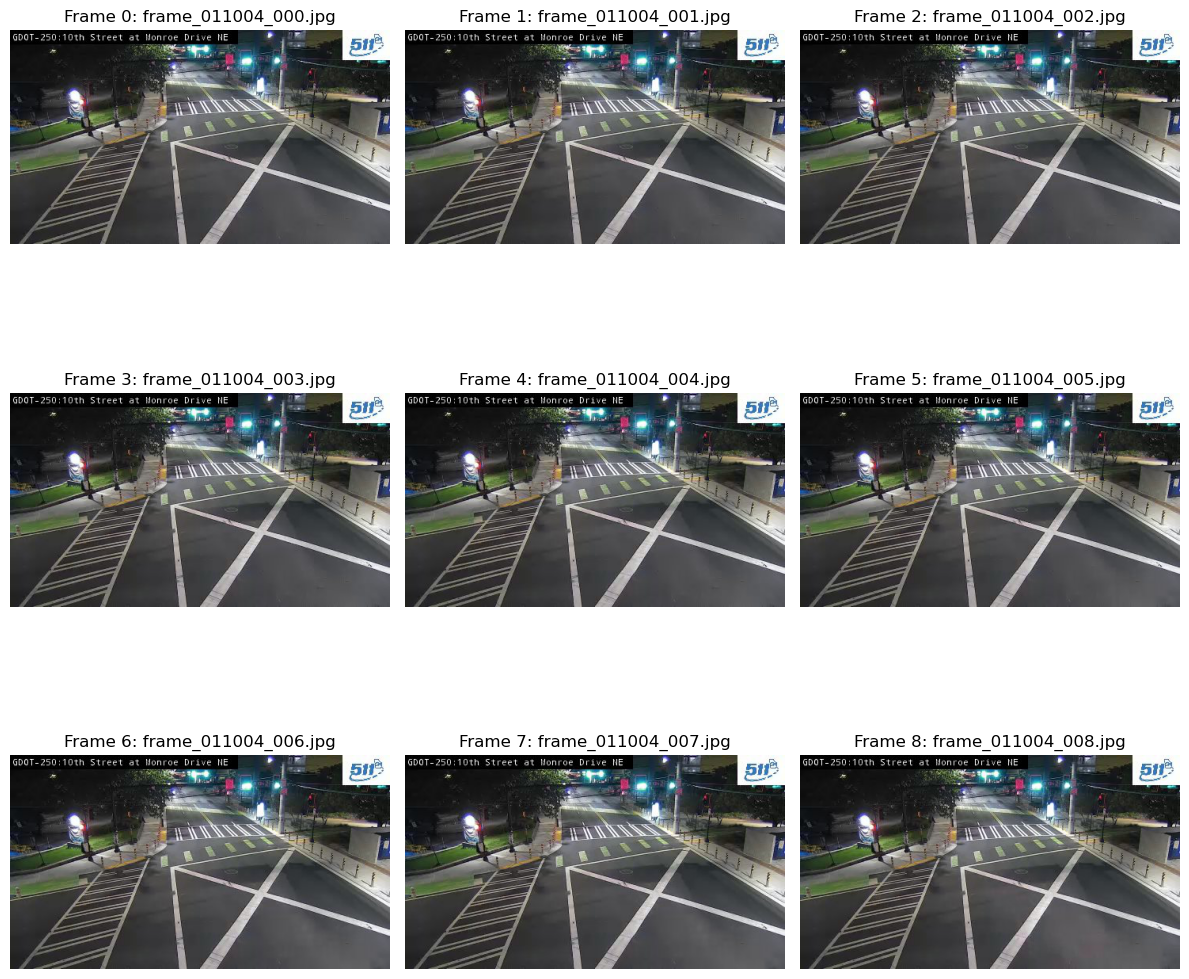

Showing first 9 frames out of 129 total frames


In [6]:
import matplotlib.pyplot as plt
import cv2

# Get the processed video folder
video_folder = list(frames_output.iterdir())[0]
frame_files = sorted(list(video_folder.glob("*.jpg")))

# Display first 9 frames in a grid
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
axes = axes.flatten()

for i, ax in enumerate(axes):
    if i < len(frame_files) and i < 9:
        # Read and convert frame from BGR to RGB
        frame = cv2.imread(str(frame_files[i]))
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        ax.imshow(frame_rgb)
        ax.set_title(f"Frame {i}: {frame_files[i].name}")
        ax.axis('off')
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()

print(f"Showing first 9 frames out of {len(frame_files)} total frames")

## Analyze Frame Quality Distribution

The next cell analyzes the distribution of quality metrics (brightness and blur scores) across all extracted frames to understand the characteristics of the video data and validate the quality thresholds.

Frame Quality Summary:
 Metric  Brightness  Blur Score
Average   80.628252 3992.297291
Minimum   77.715123 3772.839776


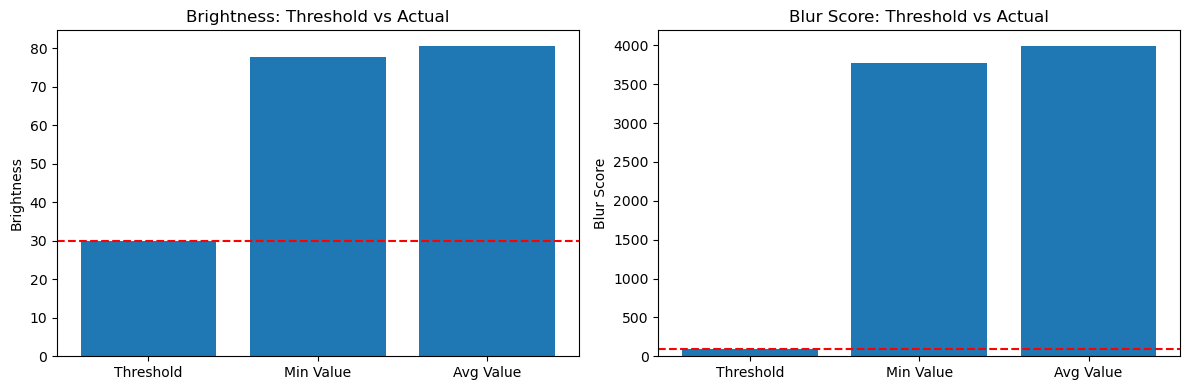

In [8]:
# Collect quality metrics from all frames
quality_data = []

# Read metadata for quality stats
with open(video_folder / "metadata.json", 'r') as f:
    metadata = json.load(f)

# Extract individual frame metrics
# Note: The current script only saves aggregated stats, not per-frame data
# For now, display the aggregated statistics

quality_stats = metadata['quality_stats']

# Create a summary dataframe
summary_df = pd.DataFrame({
    'Metric': ['Average', 'Minimum'],
    'Brightness': [quality_stats['avg_brightness'], quality_stats['min_brightness']],
    'Blur Score': [quality_stats['avg_blur_score'], quality_stats['min_blur_score']]
})

print("Frame Quality Summary:")
print(summary_df.to_string(index=False))

# Visualize thresholds vs actual values
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Brightness comparison
ax1.bar(['Threshold', 'Min Value', 'Avg Value'], 
        [30, quality_stats['min_brightness'], quality_stats['avg_brightness']])
ax1.set_ylabel('Brightness')
ax1.set_title('Brightness: Threshold vs Actual')
ax1.axhline(y=30, color='r', linestyle='--', label='Quality Threshold')

# Blur score comparison  
ax2.bar(['Threshold', 'Min Value', 'Avg Value'],
        [100, quality_stats['min_blur_score'], quality_stats['avg_blur_score']])
ax2.set_ylabel('Blur Score')
ax2.set_title('Blur Score: Threshold vs Actual')
ax2.axhline(y=100, color='r', linestyle='--', label='Quality Threshold')

plt.tight_layout()
plt.show()

## Process All Daytime Videos

The following cell runs the updated preprocessing script that automatically finds and processes all videos from 13:00 EST across all cameras and dates, maintaining the same directory structure as the original recordings.

In [20]:
# Run the batch preprocessing for all 13:00 videos
cmd = [
    "python", 
    str(SCRIPTS_DIR / "preprocess_daytime_videos.py")
]

print("Running batch preprocessing for all 13:00 EST videos...")

# Execute
result = subprocess.run(cmd, capture_output=True, text=True, cwd=SCRIPTS_DIR)

# Parse output for summary
if result.returncode == 0:
    output_lines = result.stdout.strip().split('\n')
    
    # Extract key info
    for line in output_lines:
        if "Found" in line and "total videos" in line:
            print(line)
        elif "Processing complete!" in line:
            print("\n✓ Processing complete")
        elif "Total videos processed:" in line:
            print(line)
        elif "Total frames extracted:" in line:
            print(line)
else:
    print("✗ Error occurred")
    if result.stderr:
        print(result.stderr)

Running batch preprocessing for all 13:00 EST videos...
Found 69 total videos from 13:00 EST:

✓ Processing complete
  Total videos processed: 69
  Total frames extracted: 8841


## Process All Daytime Videos

The following cell runs the preprocessing script that automatically finds all videos from 13:00 EST across all cameras and dates. The script intentionally extracts frames from only the first 60 seconds of each 15-minute video to create a manageable dataset for initial MLOps development. The output maintains the same directory structure as the original recordings.

In [19]:
# Verify batch processing results
frames_extracted = 0
cameras_processed = set()
dates_processed = set()
videos_processed = 0

# Scan the frames directory
if FRAMES_DIR.exists():
    for camera_dir in FRAMES_DIR.iterdir():
        if camera_dir.is_dir() and camera_dir.name.startswith('ATL-'):
            cameras_processed.add(camera_dir.name)
            
            for date_dir in camera_dir.iterdir():
                if date_dir.is_dir():
                    dates_processed.add(date_dir.name)
                    
                    for video_dir in date_dir.iterdir():
                        if video_dir.is_dir():
                            # Count frames
                            frame_count = len(list(video_dir.glob("*.jpg")))
                            if frame_count > 0:
                                videos_processed += 1
                                frames_extracted += frame_count

print(f"Batch Processing Summary:")IS T
print(f"  Cameras processed: {len(cameras_processed)} - {sorted(cameras_processed)}")
print(f"  Dates covered: {len(dates_processed)} - {sorted(dates_processed)}")
print(f"  Videos processed: {videos_processed}")
print(f"  Total frames extracted: {frames_extracted}")
print(f"  Average frames per video: {frames_extracted/videos_processed:.1f}" if videos_processed > 0 else "")

Batch Processing Summary:
  Cameras processed: 0 - []
  Dates covered: 0 - []
  Videos processed: 0
  Total frames extracted: 0



## Preview Frames from Each Camera

The following cell displays a sample frame from each of the 7 cameras to visually inspect the different viewpoints and video quality across locations.

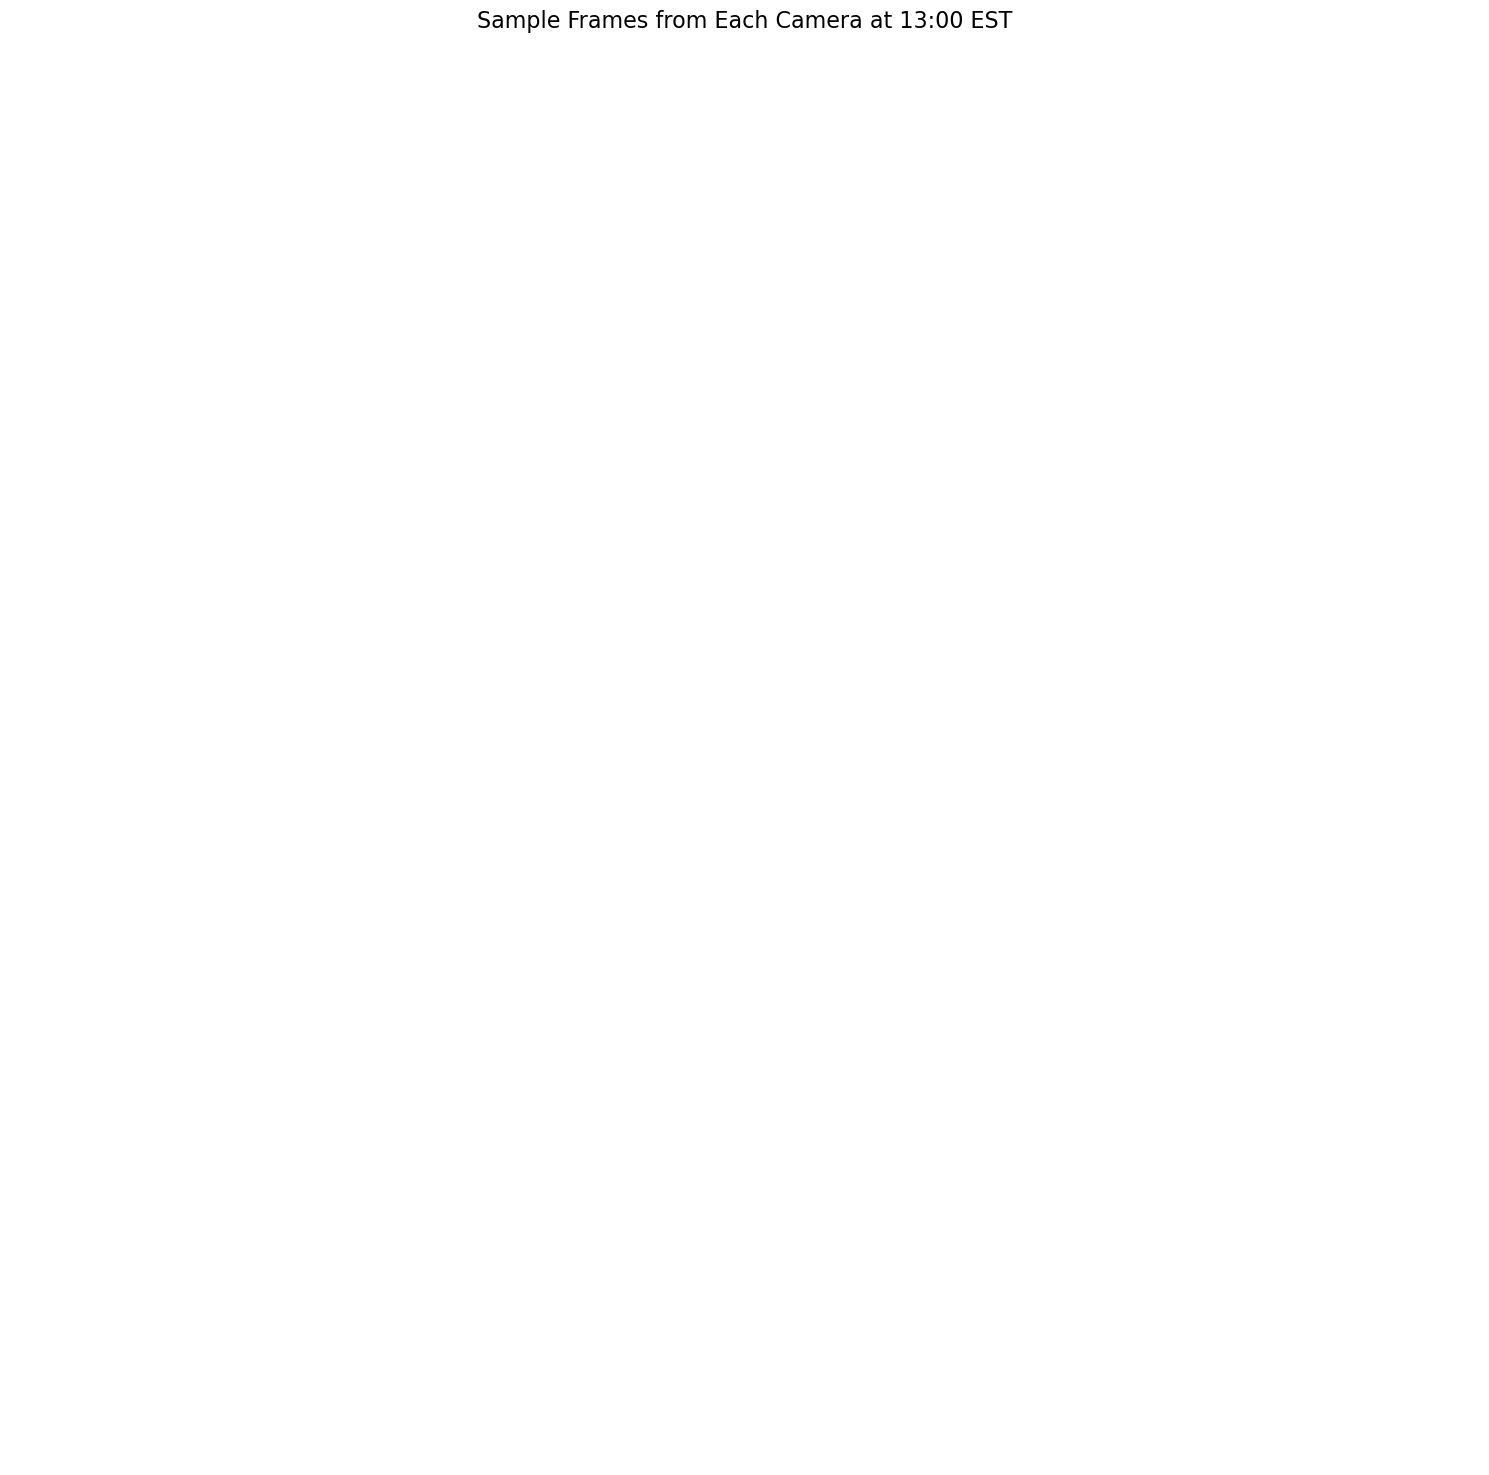

Displaying sample frames from 0 cameras


In [21]:
import matplotlib.pyplot as plt
import cv2

# Get one sample frame from each camera
sample_frames = {}
cameras = sorted(cameras_processed)

for camera in cameras:
    camera_path = FRAMES_DIR / camera
    
    # Find first available video with frames
    for date_dir in camera_path.iterdir():
        if date_dir.is_dir():
            for video_dir in date_dir.iterdir():
                if video_dir.is_dir():
                    frames = list(video_dir.glob("*.jpg"))
                    if frames:
                        # Get first frame
                        sample_frames[camera] = frames[0]
                        break
            if camera in sample_frames:
                break

# Display frames in grid
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.flatten()

for i, (camera, frame_path) in enumerate(sorted(sample_frames.items())):
    if i < len(axes):
        # Read and convert frame
        frame = cv2.imread(str(frame_path))
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        axes[i].imshow(frame_rgb)
        axes[i].set_title(f"{camera}\n{frame_path.parent.parent.name}", fontsize=10)
        axes[i].axis('off')

# Hide unused subplots
for i in range(len(sample_frames), len(axes)):
    axes[i].axis('off')

plt.suptitle("Sample Frames from Each Camera at 13:00 EST", fontsize=16)
plt.tight_layout()
plt.show()

print(f"Displaying sample frames from {len(sample_frames)} cameras")

## Create Preprocessing Summary Dataset

The following cell creates a comprehensive summary of all preprocessed videos, including metadata and quality metrics, which will be useful for the next MLOps steps (annotation and model training).

In [17]:
# Collect metadata from all processed videos
preprocessing_summary = []

for camera_dir in FRAMES_DIR.iterdir():
    if camera_dir.is_dir() and camera_dir.name.startswith('ATL-'):
        camera_id = camera_dir.name
        
        for date_dir in camera_dir.iterdir():
            if date_dir.is_dir():
                date = date_dir.name
                
                for video_dir in date_dir.iterdir():
                    if video_dir.is_dir():
                        metadata_file = video_dir / "metadata.json"
                        
                        if metadata_file.exists():
                            with open(metadata_file, 'r') as f:
                                metadata = json.load(f)
                            
                            # Extract summary info
                            preprocessing_summary.append({
                                'camera_id': camera_id,
                                'date': date,
                                'video_name': metadata['source_video'],
                                'frames_extracted': metadata['total_frames'],
                                'avg_brightness': metadata['quality_stats']['avg_brightness'],
                                'avg_blur_score': metadata['quality_stats']['avg_blur_score'],
                                'min_brightness': metadata['quality_stats']['min_brightness'],
                                'min_blur_score': metadata['quality_stats']['min_blur_score'],
                                'processing_time': metadata['processing_time']
                            })

# Create dataframe
summary_df = pd.DataFrame(preprocessing_summary)
print(f"Preprocessing Summary Statistics:")
print(f"Total videos processed: {len(summary_df)}")
print(f"\nFrames per camera:")
print(summary_df.groupby('camera_id')['frames_extracted'].sum().sort_values(ascending=False))
print(f"\nAverage quality metrics:")
print(f"  Brightness: {summary_df['avg_brightness'].mean():.1f} (±{summary_df['avg_brightness'].std():.1f})")
print(f"  Blur Score: {summary_df['avg_blur_score'].mean():.1f} (±{summary_df['avg_blur_score'].std():.1f})")

# Save summary to CSV
summary_path = PROJECT_ROOT / "preprocessing_summary.csv"
summary_df.to_csv(summary_path, index=False)
print(f"\nSummary saved to: {summary_path}")

Preprocessing Summary Statistics:
Total videos processed: 69

Frames per camera:
camera_id
ATL-0610    1290
ATL-0972    1290
ATL-0997    1290
ATL-1005    1290
ATL-0999    1273
ATL-0907    1269
ATL-0998    1139
Name: frames_extracted, dtype: int64

Average quality metrics:
  Brightness: 103.7 (±6.8)
  Blur Score: 3661.8 (±1142.0)

Summary saved to: /home/trauco/data-science-sad/preprocessing_summary.csv


## Preprocessing Complete - Ready for Annotation

The preprocessing workflow has successfully extracted frames from all 13:00 EST videos across all cameras. The data is now organized and ready for the next MLOps stage: data annotation.

**Note:** I am intentionally extracting frames from only the first 60 seconds of each 15-minute video. This creates a manageable dataset for refining the MLOps techniques before scaling to full video processing.

### Next Steps
1. **Data Annotation** - Label vehicles, pedestrians, and other objects in the extracted frames
2. **Model Training** - Use annotated data to train object detection models
3. **Model Evaluation** - Assess model performance on test data

The preprocessed frames are stored in the same hierarchical structure as the original videos, making it easy to track which frames came from which camera and time period.